<h2 style="color:purple"> SA&S </h2>
<h4 style="color:purple"> Serie A Analysis and Prediction </h4>

#### Lorenzo Didomenico
<div>
<span style="font-size:1em; font-style:italic">Instagram:@lorydidomenic</span><br>
<span style="font-size:1em; font-style:italic">Github:lorenzodidomenic</span><br>
    <span style="font-size:0.7em; font-style:italic">Palazzolo Acreide</span>
</div>

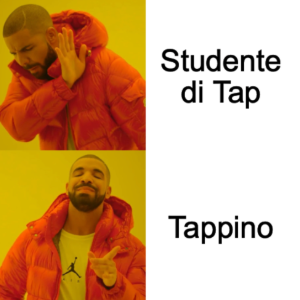

<span> SA&S </span> <br>
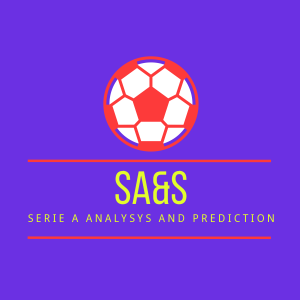

<span style="font-size:0.6em;"> Questo progetto analizzale stastitiche dei Club Di Serie A dal 2011 al 2024 per poter analizaree predire la posizione in classifica sulla base di determinati dati</span>

<span style="font-size:0.7em;"> La posizione in classifica di un club in una determinata stagione dipende infatti da fattori: 
<ul>
    <li style="font-size:0.7em;"> Partite Vinte </li>
    <li style="font-size:0.7em;"> Partite Perse </li> 
    <li style="font-size:0.7em;"> Partite Pareggiate </li>
    <li style="font-size:0.7em;"> Punti Fatti </li>
    <li style="font-size:0.7em;"> Goal Fatti </li>
    <li style="font-size:0.7em;"> Goal Subiti </li>
</ul>
</span>

<span style="font-size:0.6em;"> A partire da questi parametri possiamo quindi predire la posizione in classifica di un determinato club. </span> <br>

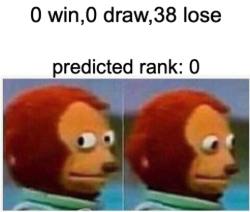


<span style="font-size:1em">
L'applicazione sarà in grado di: 
<ul>
    <li style="font-size:0.7em;"> Analizzare le exepected standings e confrontarle con le effettive classifiche per gli anni passati </li>
    <li style="font-size:0.7em;"> Simulare il posizionamento in classifica in una determinata stagione di un determinato club a partire da determinate statistiche  </li>
    <li style="font-size:0.7em;">Simulare una classifica a partire da dati randomici in una determinata stagione </li>
</ul>
</span>

<h2> Road map del progetto </h2>

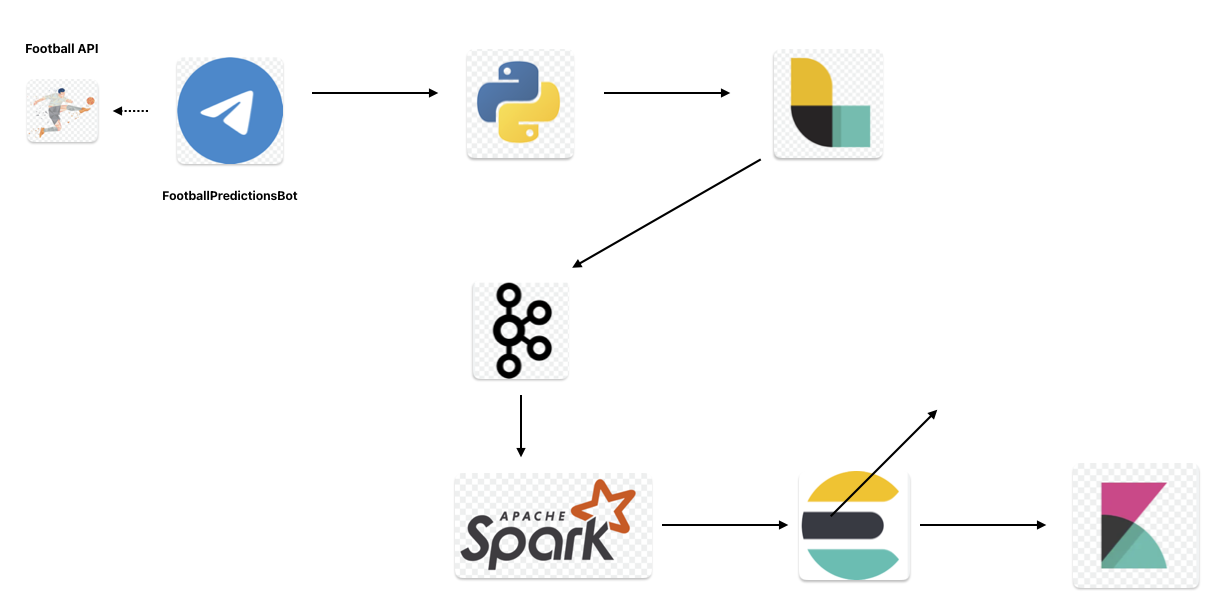

<div>
    <h5> Fase 1 </h5> 
    <span style="font-size:0.7em">
    L'applicazione parte con una comunicazione tramite il bot Telegram e lo script python , grazie alle Api fornite da <b>Telegram</b>
    </span>
</div>

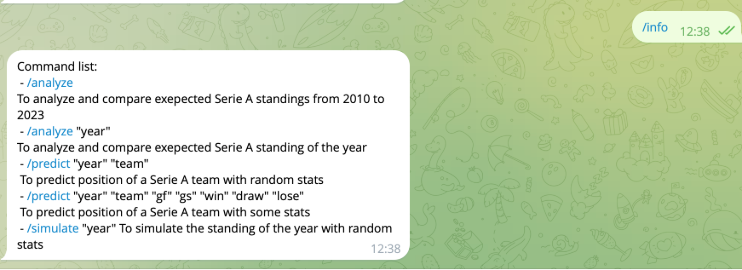

<span style="font-size:0.8em">
Nel caso di una richiesta di tipo <b>/analyze</b> in breve lo script farà una richiesta del tipo: 

In [ ]:
#the url is an env variable of the container where run the bot
#the id is the id of the league that Api expect
url = str(os.environ["URL"])+"league="+str(id)+"&season="+str(i) 
response = requests.request("GET", url, headers=headers, data=payload)
json_object = json.loads(response.text)  # i create a json object from the response

<span style="font-size:0.8em">
Nel caso di una richiesta di tipo <b>/predict</b> o <b>/simulate</b> lo script genererà un json inizializzando i campi o con valori randomici o con quelli passati dall'utente

In [ ]:
#user defined function that generate a text with required format
response = generate_json(year,team,points,win,draw,lose,gol_for,gol_against)
json_object = json.loads(response)  # i create a json object from the response created

<div>
    <h5> Fase 2 </h5> 
    <span style="font-size:0.7em">
    Lo script python invia i dati a Logstash. In particolare invierà un json contenente le statistiche ottenute.
    </span>
</div>

In [ ]:
#logstash is the container name of the container with logstash
r = requests.request("POST",url="http://logstash:8080",json=json_object)  

 <span style="font-size:0.7em">
  <b> Logstash </b> pulirà il dato che gli arriva eliminando tutti i campi che non sono utili ( grazie ai <it> filter </it> ) a <b> Spark </b> nell'analisi dei dati. <br> 
Dopo aver 'pulito' il dato lo manda sul topic SerieA creato all'interno di <b> Kafka </b>
    </span>

In [ ]:

#riceve i dati mandati dallo script python alla porta 8080
input{
     http{
        port => 8080
    }
}

#filter ...

#scrive il dato su un topic di kafka
output {
  kafka {
    codec => json
    topic_id => "topicSerieA"
    bootstrap_servers => "kafkaServer:9092"
  }
}



<span style="font-size:0.7em">
    I dati sono adesso presenti all'interno del topic Serie A in kafka.  Abbiamo creato il topic lanciando un container Kafka con entrypoint l'eseguibile per la creazione del topic 
</span>

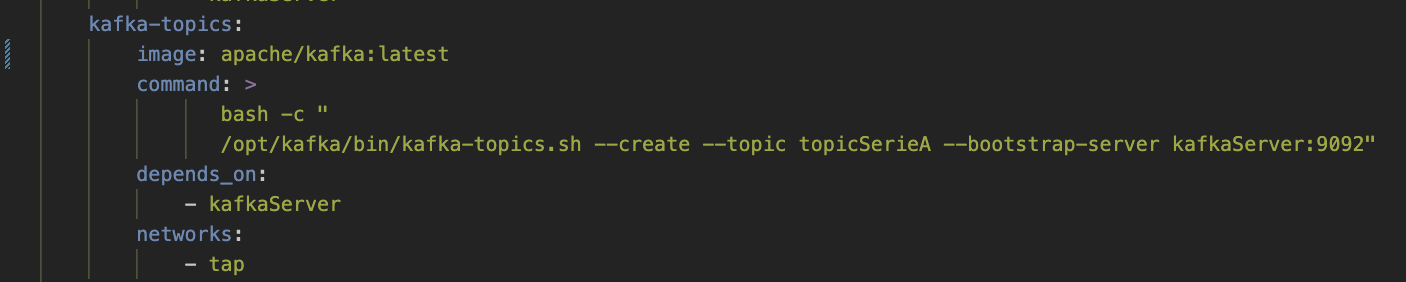

<span style="font-size:0.7em">
Possiamo vedere come il dato che arriva sul topic sia ripulito rispetto al dato iniziale grazie al lavoro di <b>Logstash</b>
</span>

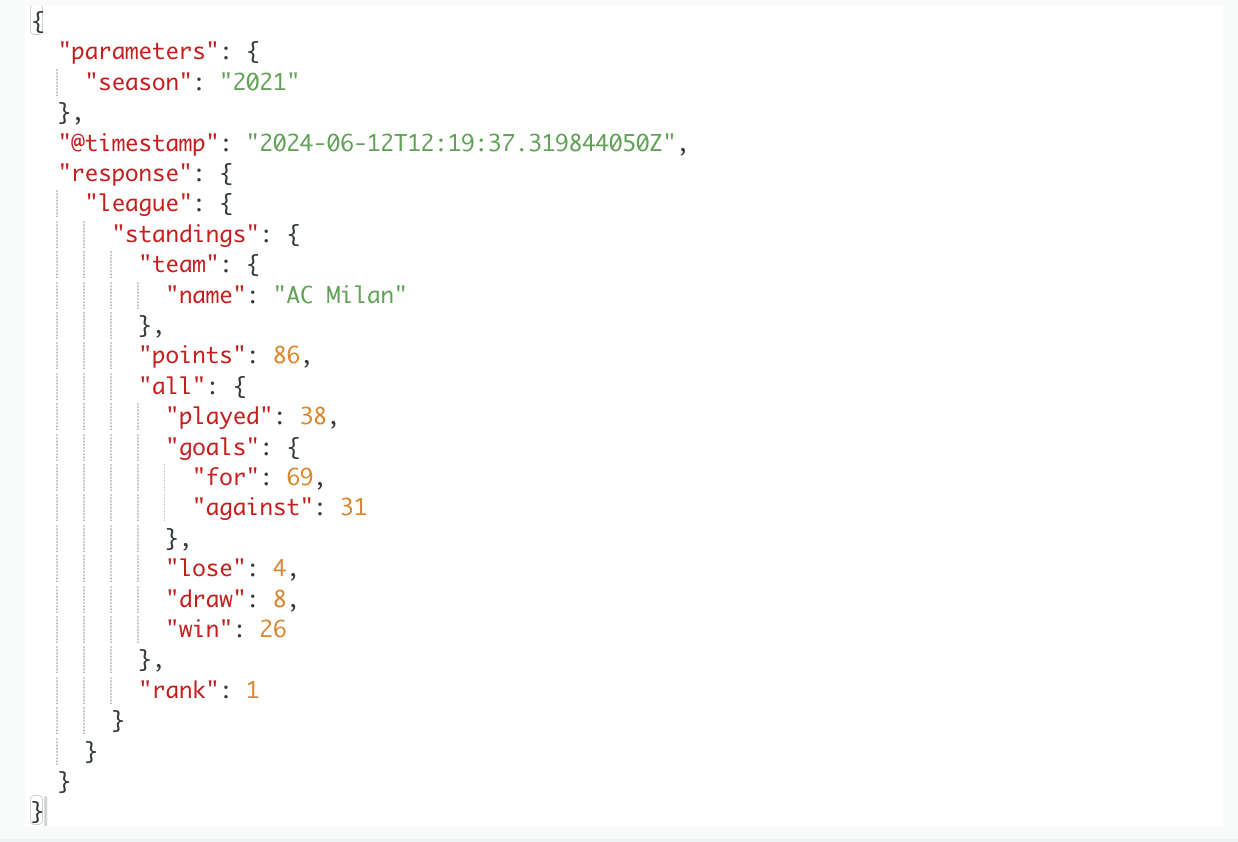

<div>
    <h5> Fase 3 </h5> 
    <span style="font-size:0.7em">
    Il cuore della nostra applicazione. In questa l'applicazione utilizza il modello allenato sulle statistiche della serie A dal 2005 al 2023 per analizzare il dato richiesto dall'utente e predire tramite la <b> Regressione Lineare </b> il valore atteso del ranking in base ai dati arrivati.
    </span>
</div>

<span style="font-size:0.7em">
<b> Fase 3.1 </b> 
Alleniamo il modello passando a spark il nostro script di training. Esso in particolare legge uno storico dei dati da un file csv  e allenando: </span>

In [ ]:
training = spark.read.format("csv").options(header='true',inferschema='true',delimiter=",").load("/tmp/data.csv")
featureassembler = VectorAssembler(inputCols = ["points","for","against","win","draw","lose"],outputCol = "features") #definisco le colonne che saranno i parametri della predizione
lr = LinearRegression(featuresCol="features",labelCol="rank",predictionCol="Predicted_rank")
pipeline = Pipeline(stages=[featureassembler,lr])
model = pipeline.fit(training)

<span style="font-size:0.7em"> 
Questo modello lo salviamo all'interno di un volume condiviso che abbiamo montato al container con <b> Spark </b>. 
Salvandolo possiamo caricarlo ed utilizzando quando vogliamo
</span>

In [ ]:
model.save("/tmp/footbAllVolume/Completemodel") 


<span style="font-size:0.7em">
<b> Fase 3.2 </b>
La fase cruciale della nostra applicazione. All'avvio dell'applicazione passiamo a spark-submit il nostro scirpt in pyspark. <br> 
Questo script crea un Datastream con i dati richiesti ogni volta dall'utente e arrivati sul topic Kafka. 
<br> 
</span>

In [ ]:
#mi leggo lo stream da kafka
df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", kafkaServer) \
  .option("failOnDataLoss", False)\
  .option("subscribe", topic) \
  .load()

<span style="font-size:0.7em">
Su questi dati ne crea una struttura e passa il dato al modello pre-addestrato. <br> 
Esso a partire dai dati arrivati calcola un <b> Predicted Rank </b>. Il Predicted Rank potrebbe pure essere anche un numero negativo o superiore alla massia posizione possibile. Per evitare questo uso una UDF function per settare minimo e massimo valore predetto <br>
</span>

In [ ]:
#....see the code to view the structure building

model = PipelineModel.load(modelPath)  #carico il modello

def map_(x):
    if x <= 0: 
      x =1.0 
    elif x >= 20:
      x= 20.0
    return x
map_udf = udf(map_,FloatType())    #la trasformo in udf function

predictDf = model.transform(parseDf).select('@timestamp','name','season','rank','Predicted_rank',"for","against","win","draw","lose")
predictDf = predictDf.withColumn("Predicted_rank",map_udf("Predicted_rank"))

<span style="font-size:0.7em">
Ogni volta che arriva il dato e quindi l'ho processato lo mando ad <b> ElasticSearch </b>
</span>

In [ ]:
#mando ad elastic
predictDf.writeStream \
   .option("checkpointLocation", "/tmp/") \
   .format("es") \
   .start(elastic_index) \
   .awaitTermination()

<div>
    <h5> Fase 4 </h5> 
    <span style="font-size:0.7em">
    La fase finale della nostra applicazione e la più "visibile". I dati arrivano ad <b>Elastic</b> in un unico indice 'football' e grazie a <b> Kibana </b> l'applicazione fa un confornto fra l'effettiva classifica di Serie A in una determinata stagione e quella predetta dal modello sui dati che gli arrivano. 
    </span>
</div>

<h2> Let's go </h2>